In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

import re


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,accuracy_score,classification_report



from sklearn.feature_extraction.text import TfidfVectorizer

from tensorflow import keras
from keras import layers
from tensorflow.keras.utils import plot_model

from wordcloud import WordCloud


import warnings
warnings.filterwarnings("ignore")


%matplotlib inline


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [7]:
data=pd.read_csv('/movie.csv')
data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


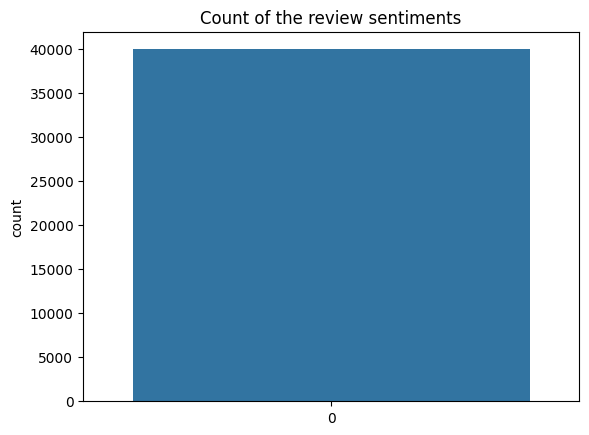

0    20019
1    19981
Name: label, dtype: int64


In [8]:
sns.countplot(data['label'])
plt.title('Count of the review sentiments')
plt.show()
print(data['label'].value_counts())

In [9]:
def get_visuals(df,column_name,value):
    s=','
    for element in df[df[column_name]==value]['text']:
        s+=str(element)

    wordcloud=WordCloud(background_color='white',
                    random_state=101,
                   width=800,
                   height=800).generate(s)

    plt.figure(figsize=(12,8))
    plt.axis('off')
    plt.grid(False)
    plt.imshow(wordcloud)
    plt.show()


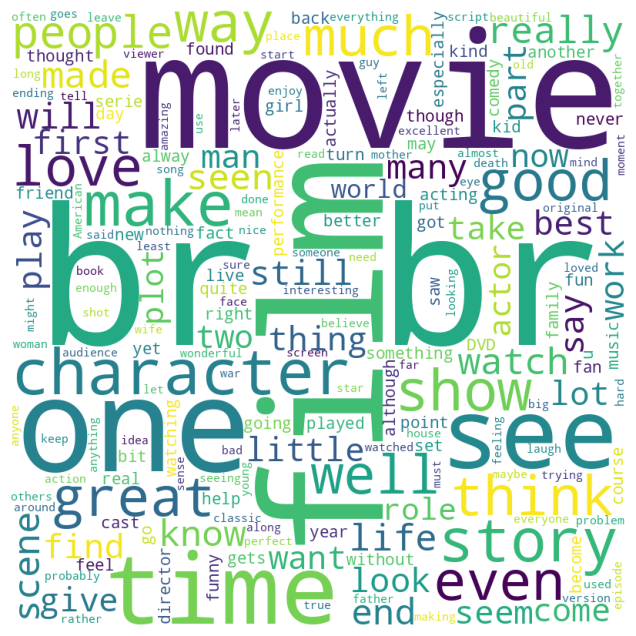

In [10]:
get_visuals(data,'label',1)

In [11]:
pos_rev=data[data['label']==1][:5000]
neg_rev=data[data['label']==0][:5000]

new_data=pd.concat([pos_rev,neg_rev],axis=0)
new_data.head()

,text,label
4,Im a die hard Dads Army fan and nothing will e...,1
6,Finally watched this shocking movie last night...,1
8,It may be the remake of 1987 Autumn's Tale aft...,1
9,My Super Ex Girlfriend turned out to be a plea...,1
10,I can't believe people are looking for a plot ...,1


In [12]:
final_data=new_data.sample(frac=1)
final_data.head()

,text,label
2508,One of the finest movies I have viewed...Good ...,1
941,A lot people get hung up on this films tag as ...,1
3650,"If you're researching UFO facts, then this vid...",1
9485,Considering the risk of showing same-sex relat...,0
4799,I was a schoolboy when I watched this film for...,1


In [13]:
final_data['label'].value_counts()

1    5000
0    5000
Name: label, dtype: int64

In [21]:
def prepare_data(df, column_name):
    try:
        data = df[column_name]
        useless_words = set(stopwords.words('english') + list(punctuation) + ['<br />'])

        lemmatizer = WordNetLemmatizer()
        corpus = data.tolist()
        final_corpus = []

        for i in range(len(corpus)):
            words = word_tokenize(corpus[i].lower())
            words = [lemmatizer.lemmatize(word) for word in words if word not in useless_words]
            text = " ".join(words)
            text = re.sub(r'[^\w\s]', ' ', text)
            text = re.sub("(^|\W)\d+", " ", text)

            final_corpus.append(text)

        return final_corpus
    except Exception as e:
        print(f"Error in prepare_data: {e}")
        return None


In [26]:
final_corpus = prepare_data(final_data, 'text')

if final_corpus is not None:
    label_ = final_data['label']
    train_df = {
        'label': label_,
        'content': final_corpus,
    }

    train_df = pd.DataFrame(train_df)
    train_df.head()
else:
    print("Data preparation failed.")

In [27]:
tf=TfidfVectorizer()
vector=tf.fit_transform(train_df['content'])
x=vector.toarray()
y=train_df['label']

x

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [28]:
X_train,X_test,Y_train,Y_test=train_test_split(x,y,test_size=0.18,random_state=101)

In [29]:
model_names=['Logistic Regression','Multinomial Naive Bayes']
model=[LogisticRegression(),MultinomialNB()]

def get_results(model_names,model,x_train,x_test,y_train,y_test):


    model_accuracy_score=[]
    model_auc_score=[]

    for i in model:
        model_=i.fit(x_train,y_train)
        y_preds=model_.predict(x_test)

        score1=accuracy_score(y_test,y_preds)
        score2=roc_auc_score(y_test,y_preds,)

        model_accuracy_score.append(score1)
        model_auc_score.append(score2)

    result={
        'Model':model_names,
        'AUC Score': model_auc_score,
        'Accuracy Score': model_accuracy_score
    }

    result=pd.DataFrame(result)

    return result

In [30]:
comp_df=get_results(model_names,model,X_train,X_test,Y_train,Y_test)

In [31]:
comp_df

,Model,AUC Score,Accuracy Score
0,Logistic Regression,0.863875,0.864444
1,Multinomial Naive Bayes,0.843427,0.838889


In [32]:
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(train_df['content'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 47222 unique tokens.


In [33]:
X = tokenizer.texts_to_sequences(train_df['content'].values)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (10000, 250)


In [34]:
Y = pd.get_dummies(train_df['label']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (10000, 2)


In [35]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 101)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(8000, 250) (8000, 2)
(2000, 250) (2000, 2)


In [36]:
model = keras.Sequential()
model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(keras.layers.SpatialDropout1D(0.2))
model.add(keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 5080602 (19.38 MB)
Trainable params: 5080602 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs,steps_per_epoch=100, batch_size=batch_size,validation_split=0.2)

Epoch 1/5
100/100 [==============================] - 91s 837ms/step - loss: 0.5299 - accuracy: 0.7156 - val_loss: 0.3650 - val_accuracy: 0.8462
Epoch 2/5
100/100 [==============================] - 82s 815ms/step - loss: 0.2771 - accuracy: 0.8906 - val_loss: 0.3662 - val_accuracy: 0.8475
Epoch 3/5
100/100 [==============================] - 77s 769ms/step - loss: 0.0916 - accuracy: 0.9695 - val_loss: 0.4036 - val_accuracy: 0.8425
Epoch 4/5
100/100 [==============================] - 80s 798ms/step - loss: 0.0301 - accuracy: 0.9909 - val_loss: 0.5268 - val_accuracy: 0.8531
Epoch 5/5
100/100 [==============================] - 77s 769ms/step - loss: 0.0165 - accuracy: 0.9966 - val_loss: 0.5248 - val_accuracy: 0.8444


In [39]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

63/63 [==============================] - 8s 115ms/step - loss: 0.5754 - accuracy: 0.8375
Test set
  Loss: 0.575
  Accuracy: 0.837


In [40]:
def get_plot(trained_model,no_epochs):
    accuracy=trained_model.history['accuracy']
    loss=trained_model.history['loss']
    val_accuracy=trained_model.history['val_accuracy']
    val_loss=trained_model.history['val_loss']
    epochs=[i for i in range(1,no_epochs+1)]

    plt.figure(figsize=(12,8))
    plt.plot(epochs,accuracy,'r',label='Training')
    plt.plot(epochs,val_accuracy,'--',label='Validation')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy',fontsize=15)
    plt.grid()
    plt.show()

    plt.figure(figsize=(12,8))
    plt.plot(epochs,loss,'r',label='Training')
    plt.plot(epochs,val_loss,'--',label='Validation')
    plt.legend()
    plt.title('Loss',fontsize=15)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()
    plt.show()

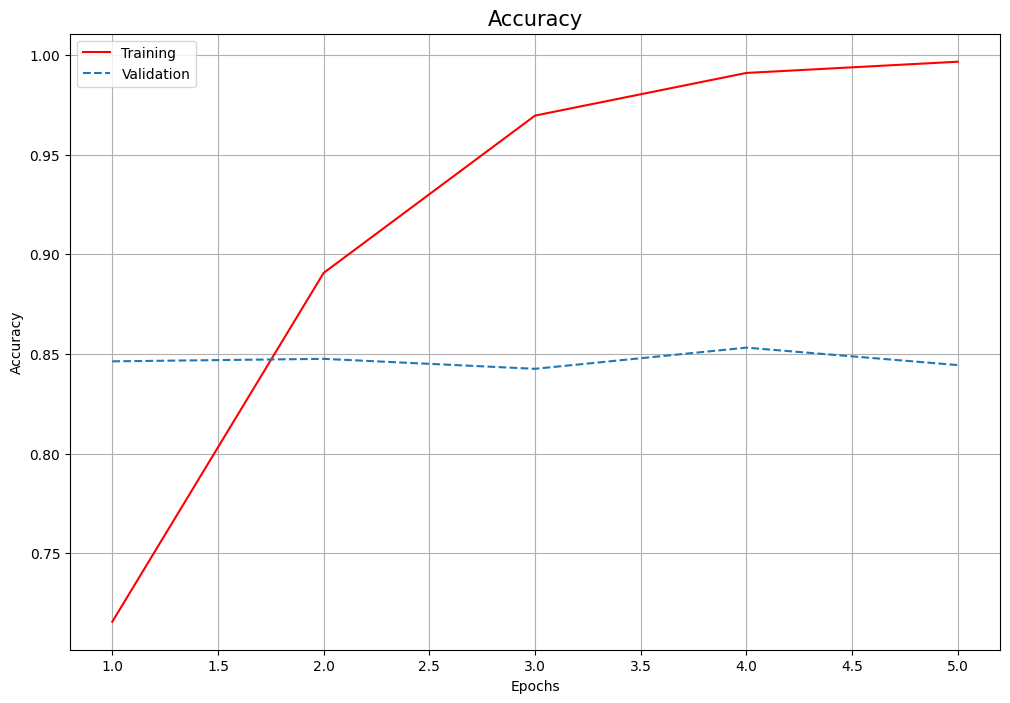

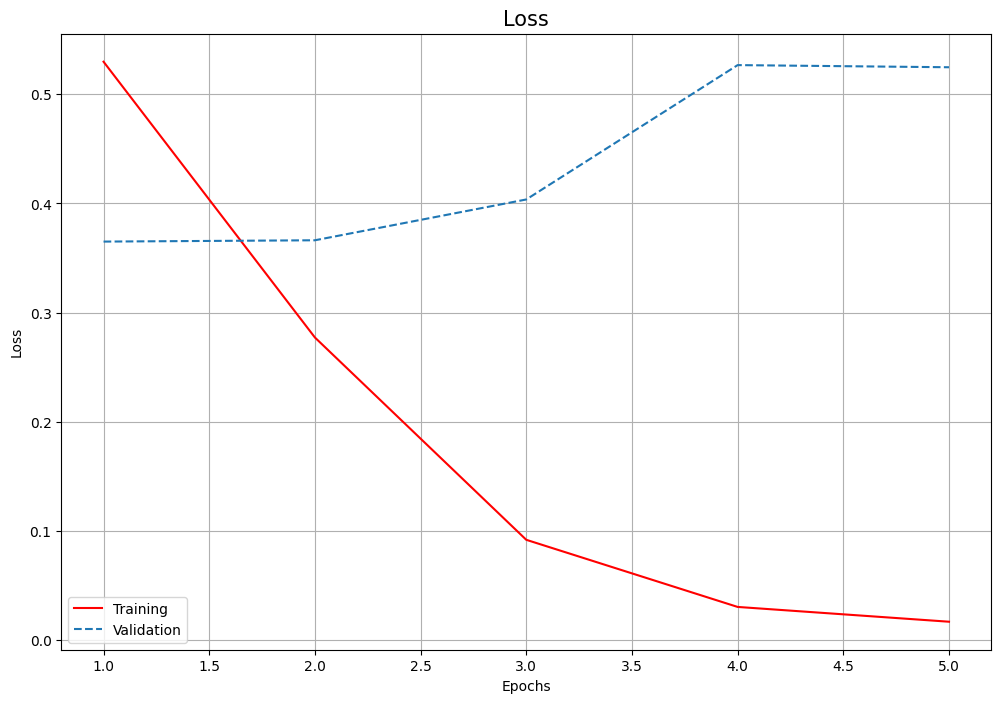

In [41]:
get_plot(history,5)